In [10]:
from concurrent.futures import ThreadPoolExecutor
import ffmpeg
from IPython.display import Audio
from matplotlib import pyplot as plt
import noisereduce as nr
import numpy as np
import os
from pathlib import Path
import torch
from tqdm.notebook import tqdm
from functools import partial

from functions.dl.network_components import AudioToLogSpectrogram
from functions.processing.recordings import process_and_save_as_pt, add_white_noise, modulate_volume, random_cutout, pitch_warp, apply_augmentation_transforms, create_data_augmentation, get_noise_profile, denoise_data
from functions.processing.retrieval import loadPT
from functions.plotting.spectrograms import plot_spectrograms_dual


In [2]:
# --- Setup Paths ---
input_dir = Path("Z:\\Audio_data\\Dawn_chorus_conversion_flac")
output_dir = Path("./AudioTensors")
output_dir.mkdir(exist_ok=True)

# Find all files
audio_files = list(input_dir.glob("*.flac"))

print(f"Total files to process: {len(audio_files)}")

# --- Execution ---
# We use max_workers to run multiple FFmpeg instances at once
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    # Use a list to hold the results so tqdm can track progress
    results = list(tqdm(
        executor.map(lambda f: process_and_save_as_pt(f, output_dir, target_sr=16000), audio_files), 
        total=len(audio_files),
        desc="Converting to .pt"
    ))

print(f"Success: {sum(results)} | Failed: {len(results) - sum(results)}")

Total files to process: 0


Converting to .pt: 0it [00:00, ?it/s]

Success: 0 | Failed: 0


In [2]:
input_dir = Path("./AudioTensors")
audio_files = list(input_dir.glob("*.pt"))

In [4]:
tens = loadPT(audio_files[0])

In [5]:
add_white_noise(tens)

tensor([-0.0001, -0.0012,  0.0031,  ...,  0.0865,  0.0900,  0.0919])

In [6]:
modulate_volume(tens)

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0960, 0.0940, 0.0940],
       dtype=torch.float16)

In [7]:
random_cutout(tens)

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0921, 0.0901, 0.0901],
       dtype=torch.float16)

In [8]:
pitch_warp(tens)

tensor([0.0000, 0.0000, 0.0000,  ..., 0.1039, 0.0957, 0.0495],
       dtype=torch.float16)

In [9]:
apply_augmentation_transforms(tens, [modulate_volume, pitch_warp, add_white_noise])

tensor([0.0014, 0.0007, 0.0039,  ..., 0.0507, 0.0531, 0.0345])

In [5]:
# --- Setup Paths ---
input_dir = Path("./AudioTensors")
output_dir = Path("./AudioTensors_data_augmentation")
output_dir.mkdir(exist_ok=True)

# Find all files
audio_files = list(input_dir.glob("*.pt"))

print(f"Total files to process: {len(audio_files)}")

# --- Execution ---
# We use max_workers to run multiple FFmpeg instances at once
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    # Use a list to hold the results so tqdm can track progress
    results = list(tqdm(
        executor.map(lambda f: create_data_augmentation(f, output_dir), audio_files), 
        total=len(audio_files),
        desc="Augmenting data."
    ))

print(f"Success: {sum(results)} | Failed: {len(results) - sum(results)}")

Total files to process: 43826


Augmenting data.:   0%|          | 0/43826 [00:00<?, ?it/s]

Success: 43826 | Failed: 0


In [4]:
input_dir = Path("./AudioTensors")
audio_files = list(input_dir.glob("*.pt"))
tens = loadPT(audio_files[0])

In [5]:
Audio(tens.squeeze().numpy(), rate=16000)

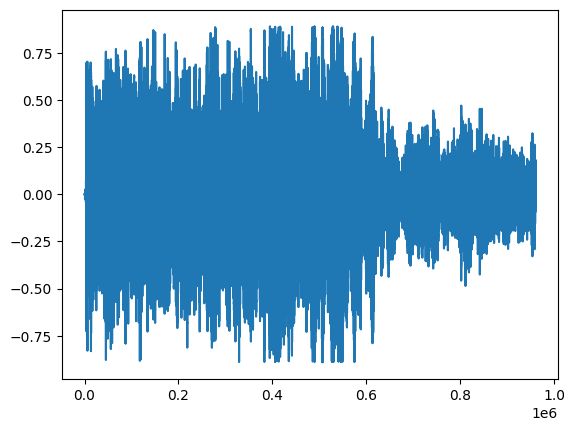

In [6]:
plt.plot(tens.squeeze().numpy())

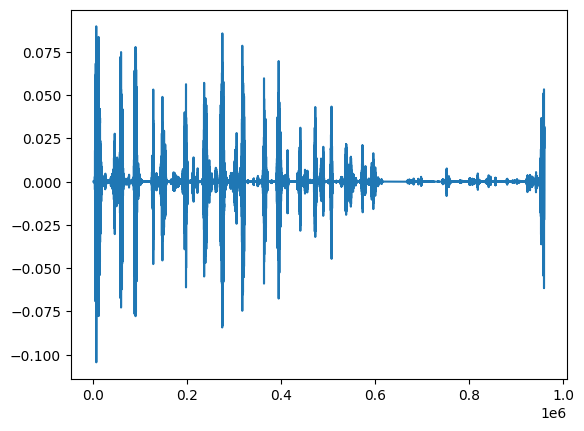

In [8]:
sampling_rate = 16000
noise_part = get_noise_profile(tens, sampling_rate, window_duration=2.5)# tens[0:int(sampling_rate*1.0)]
reduced_noise = nr.reduce_noise(
    y=tens, 
    sr=sampling_rate, 
    y_noise=noise_part, 
    n_fft=4096,      # Matches your "FFT 12" (2^12 = 4096)
    hop_length=204,  # Approx 95% overlap (4096 * 0.05)
    prop_decrease=1.0
)

plt.plot(reduced_noise)

In [9]:
Audio(reduced_noise, rate=16000)

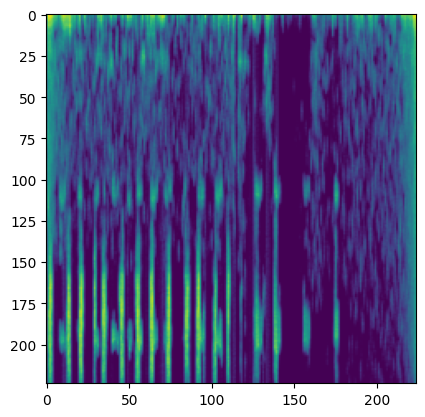

In [ ]:
atls = AudioToLogSpectrogram().to("cuda")
reduced_noise_tensor = torch.from_numpy(reduced_noise).float()
reduced_spec = atls(reduced_noise_tensor.to("cuda"))
spec = atls(tens.to("cuda"))

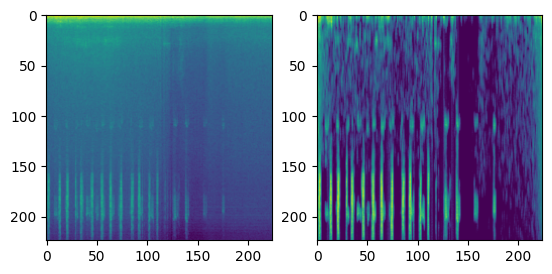

In [ ]:
fig, ax = plt.subplots(1,2)

ax[0].imshow(spec.squeeze(0).squeeze(0).to("cpu"))
ax[1].set_title("After noise reduction")
ax[1].imshow(reduced_spec.squeeze(0).squeeze(0).to("cpu"))

In [2]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"


input_dir = Path("./AudioTensors")
output_dir = Path("./AudioTensors_reduced_noise")
output_dir.mkdir(exist_ok=True)

audio_files = list(input_dir.glob("*.pt"))
print(f"Total files to process: {len(audio_files)}")

# Use a fixed number of workers to avoid OOM (Out of Memory)
# usually cpu_count() is safe if inputs are small, 
# but for audio processing, cpu_count() - 2 is safer to keep system responsive.
max_workers = max(1, os.cpu_count() - 2)

# Use ProcessPoolExecutor instead of ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Partial lets us fix arguments so we don't need a lambda
    func = partial(denoise_data, output_dir=output_dir, 
                    sampling_rate=16000, window_duration=2.5)

    results = list(tqdm(
        executor.map(func, audio_files), 
        total=len(audio_files),
        desc="Denoising data"
    ))

# Check errors
failures = [r for r in results if r is not True]
print(f"Success: {len(audio_files) - len(failures)} | Failed: {len(failures)}")
if failures:
    print(f"First error: {failures[0]}")

Total files to process: 43826


Denoising data:   0%|          | 0/43826 [00:00<?, ?it/s]

Success: 43826 | Failed: 0


In [ ]:
input_dir = Path("./AudioTensors")
audio_files = list(input_dir.glob("*.pt"))

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    # Use a list to hold the results so tqdm can track progress
    results = list(tqdm(
        executor.map(lambda f: loadPT(f), audio_files), 
        total=len(audio_files),
        desc="Loading files"
    ))

In [ ]:
input_dir = Path("./AudioTensors")
audio_files = list(input_dir.glob("*.pt"))

Getting ./AudioTensors\27255833_audio.pt
Getting ./AudioTensors\27280455_audio.pt
Getting ./AudioTensors\27275614_audio.pt
Getting ./AudioTensors\27270668_audio.pt
Getting ./AudioTensors\27315946_audio.pt
Getting ./AudioTensors\27255819_audio.pt
Getting ./AudioTensors\27305549_audio.pt
Getting ./AudioTensors\27270648_audio.pt
Getting ./AudioTensors\27275613_audio.pt


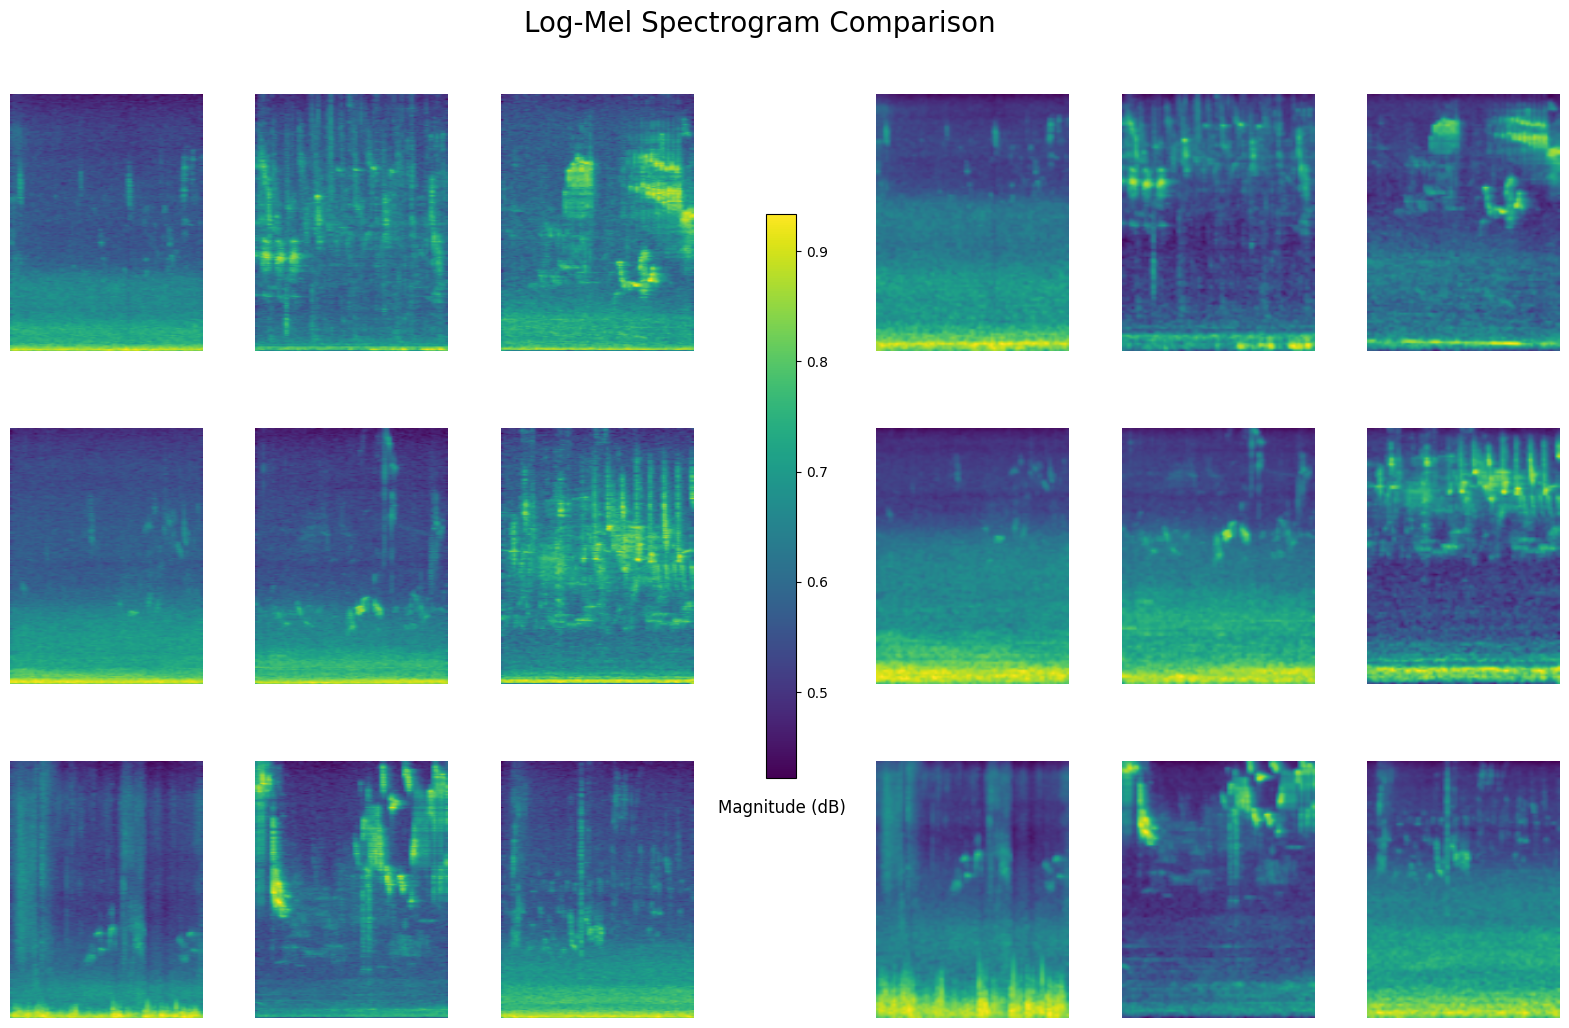

In [ ]:
plot_spectrograms_dual(audio_files)